In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [17]:
# Step 1: Simulate data
np.random.seed(42)
df = pd.DataFrame(
    {"x": np.random.normal(50, 10, 1000), "target": np.random.binomial(1, 0.4, 1000)}
)
df.shape

(1000, 2)

In [18]:
# Step 2: Manual binning
df["x_bin"] = pd.cut(df["x"], bins=[0, 40, 50, 60, 100], right=False)
df["x_bin"].value_counts()

x_bin
[50, 60)     355
[40, 50)     343
[60, 100)    155
[0, 40)      147
Name: count, dtype: int64

In [19]:
# Step 3: Calculate WoE and IV
def woe_iv(df, feature, target):
    grouped = df.groupby(feature, observed=False)[target].agg(["count", "sum"])
    grouped.columns = ["total", "bad"]
    grouped["good"] = grouped["total"] - grouped["bad"]
    dist_good = grouped["good"] / grouped["good"].sum()
    dist_bad = grouped["bad"] / grouped["bad"].sum()
    grouped["woe"] = np.log((dist_good + 1e-6) / (dist_bad + 1e-6))  # smoothing
    grouped["iv"] = (dist_good - dist_bad) * grouped["woe"]
    iv = grouped["iv"].sum()
    return grouped[["woe"]], iv, grouped


woe_table, iv, grouped = woe_iv(df, "x_bin", "target")
print("IV: {:.4f}".format(iv))
grouped

IV: 0.0191


,total,bad,good,woe,iv
x_bin,,,,,
"[0, 40)",147,53,94,0.237900,0.008121
"[40, 50)",343,137,206,0.072794,0.001806
"[50, 60)",355,162,193,-0.160007,0.009191
"[60, 100)",155,65,90,-0.009679,0.000015


In [20]:
# Step 4: Map WoE values
df = df.merge(woe_table, left_on="x_bin", right_index=True)
df.rename(columns={"woe": "x_woe"}, inplace=True)
df.head()

,x,target,x_bin,x_woe
0,54.967142,0,"[50, 60)",-0.160007
1,48.617357,0,"[40, 50)",0.072794
2,56.476885,1,"[50, 60)",-0.160007
3,65.230299,1,"[60, 100)",-0.009679
4,47.658466,0,"[40, 50)",0.072794


In [21]:
# Step 5: Logistic regression
X = sm.add_constant(df["x_woe"])
logit_model = sm.Logit(df["target"], X)
result = logit_model.fit(disp=0)
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Wed, 25 Jun 2025   Pseudo R-squ.:                0.003416
Time:                        11:44:39   Log-Likelihood:                -676.98
converged:                       True   LL-Null:                       -679.31
Covariance Type:            nonrobust   LLR p-value:                   0.03123
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3351      0.064     -5.212      0.000      -0.461      -0.209
x_woe         -1.0000      0.466     -2.148      0.032      -1.913      -0.087


Gini: 0.0754


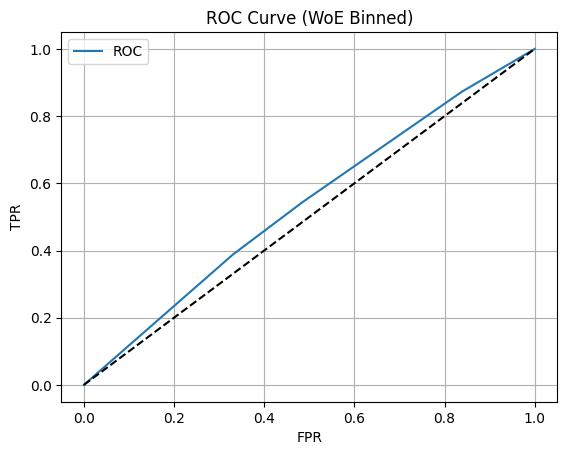

In [22]:
# Step 6: ROC + Gini
probs = result.predict(X)

auc = roc_auc_score(df["target"], probs)
gini = 2 * auc - 1
print("Gini: {:.4f}".format(gini))

fpr, tpr, _ = roc_curve(df["target"], probs)
plt.plot(fpr, tpr, label="ROC")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve (WoE Binned)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()